In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [4]:
# Define data file and read X and y
mat_file_list = ['arrhythmia.mat',
                 'cardio.mat',
                 'ionosphere.mat',
                 'mnist.mat',
                 'satellite.mat']

# Define nine outlier detection tools to be compared
random_state = np.random.RandomState(42)

df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD',
              'OCSVM', 'PCA']
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)


for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join('datasets', mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    # construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=random_state)

    # standardizing data for processing, mean=0, var=1
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(
            contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor': CBLOF(contamination=outliers_fraction, check_estimator=False,
                                                    random_state=random_state),
        'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                          random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(
            contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,
                                    random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(
            contamination=outliers_fraction),
        'Minimum Covariance Determinant (MCD)': MCD(
            contamination=outliers_fraction, random_state=random_state),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction, random_state=random_state),
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
              'execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)

In [5]:
roc_df

,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,arrhythmia,452,274,14.6018,0.7687,0.7824,0.7796,0.8511,0.8639,0.782,0.7787,0.8228,0.7986,0.7997
0,cardio,1831,21,9.6122,0.5892,0.973,0.6385,0.8373,0.9502,0.734,0.588,0.8524,0.9478,0.9616
0,ionosphere,351,33,35.8974,0.9317,0.8557,0.8855,0.6263,0.877,0.9438,0.8826,0.9534,0.8779,0.8219
0,mnist,7603,100,9.2069,0.7817,0.8763,0.7402,0.5734,0.8102,0.8431,0.7173,0.8545,0.8375,0.8372
0,satellite,6435,36,31.6395,0.5913,0.5681,0.5516,0.7508,0.6968,0.6954,0.5551,0.8127,0.6673,0.6073


In [6]:
mat_file = 'satellite.mat'
mat = loadmat(os.path.join('datasets', mat_file))

X = mat['X']
y = mat['y'].ravel()
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

In [16]:
# 75% data for training and 25% for testing. Default values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=random_state)

# standardizing data for processing, mean=0, var=1
X_train_norm, X_test_norm = standardizer(X_train, X_test)

classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(
        contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(contamination=outliers_fraction, check_estimator=False,
                                                random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                      random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

In [24]:
# 'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state)
# 'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction)

clf_name, clf = ['Isolation Forest',
                 IForest(contamination=outliers_fraction, random_state=random_state)]

clf.fit(X_train_norm)
test_scores = clf.decision_function( X_test_norm)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(clf_name=clf_name, roc=roc, prn=prn))

Isolation Forest ROC:0.7231, precision @ rank n:0.5717


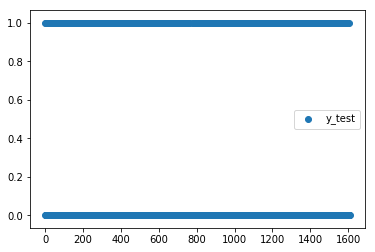

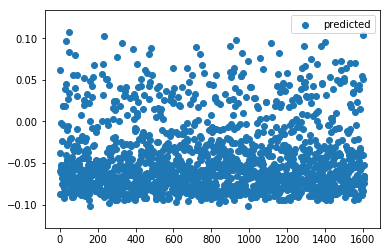

In [34]:
plt.scatter(range(len(y_test)), y_test, label='y_test')
# plt.scatter(range(len(test_scores)), test_scores, label='predicted')
plt.legend()
plt.show()

plt.scatter(range(len(test_scores)), test_scores, label='predicted')
plt.legend()
plt.show()

In [72]:
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import evaluate_print, generate_data

X_train, y_train, X_test, y_test = generate_data(n_train=200, n_test=100, n_features=2)

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.9256, precision @ rank n:0.75

On Test Data:
KNN ROC:0.9844, precision @ rank n:0.8


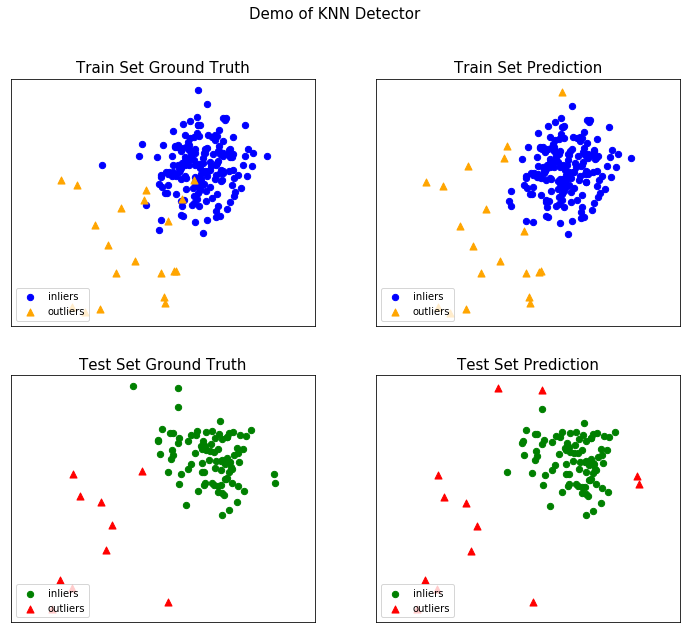

In [73]:
from pyod.utils.example import visualize

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [ ]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [74]:
clf_name, clf = ['Isolation Forest',
                 IForest(contamination=outliers_fraction, random_state=random_state)]

clf.fit(X_train_norm)
test_scores = clf.decision_function( X_test_norm)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(clf_name=clf_name, roc=roc, prn=prn))

Isolation Forest ROC:0.9711, precision @ rank n:0.7


In [ ]:
y_test_pred = clf.predict(X_test_norm)  # outlier labels (0 or 1)